In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import os
import math
import torch.nn as nn

In [2]:
# ... [前面的數據加載和預處理代碼保持不變] ...

# Path to the chest-ct-segmentation dataset folder
data_dir = "dataset\Lucchi++"
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")

i = 0
# Prepare the test data, Append image and corresponding mask paths
test_data = []
for image_file in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, f"{i}.png")
    i += 1
    test_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })

In [3]:
def read_image(image_path, mask_path):
    img = cv2.imread(image_path)[..., ::-1]
    mask = cv2.imread(mask_path, 0)
    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
    mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    return img, mask

def get_points(mask, num_points):
    points = []
    coords = np.argwhere(mask > 0)
    for i in range(num_points):
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([[yx[1], yx[0]]])
    return np.array(points)

In [4]:
import torch
import torch.nn as nn

class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank=4, scaling=1.0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.lora_down = nn.Linear(in_features, rank, bias=False)
        self.lora_up = nn.Linear(rank, out_features, bias=False)
        self.scaling = scaling

    def forward(self, x):
        return self.linear(x) + self.lora_up(self.lora_down(x)) * self.scaling

class LoRAWrapper(nn.Module):
    def __init__(self, base_model, lora_weights, rank=4, scaling=1.0):
        super().__init__()
        self.base_model = base_model
        self.lora_layers = nn.ModuleDict()
        self.name_mapping = {}

        for name, module in self.base_model.named_modules():
            if isinstance(module, nn.Linear) and any(key in name for key in ['sam_prompt_encoder', 'sam_mask_decoder']):
                lora_down_weight = lora_weights.get(f"{name}.lora_down.weight")
                lora_up_weight = lora_weights.get(f"{name}.lora_up.weight")

                if lora_down_weight is not None and lora_up_weight is not None:
                    lora_layer = LoRALinear(module.in_features, module.out_features, rank=rank, scaling=scaling)
                    lora_layer.linear.weight.data = module.weight.data
                    if module.bias is not None:
                        lora_layer.linear.bias.data = module.bias.data
                    lora_layer.lora_down.weight.data = lora_down_weight
                    lora_layer.lora_up.weight.data = lora_up_weight

                    unique_key = f"lora_{len(self.lora_layers)}"
                    self.lora_layers[unique_key] = lora_layer
                    self.name_mapping[name] = unique_key

    def forward(self, *args, **kwargs):
        def forward_hook(module, input, output):
            name = None
            for n, m in self.base_model.named_modules():
                if m is module:
                    name = n
                    break
            if name in self.name_mapping:
                return self.lora_layers[self.name_mapping[name]](input[0])
            return output

        handles = []
        for name, module in self.base_model.named_modules():
            if name in self.name_mapping:
                handle = module.register_forward_hook(forward_hook)
                handles.append(handle)

        output = self.base_model(*args, **kwargs)

        for handle in handles:
            handle.remove()

        return output

    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.base_model, name)

def add_lora_to_model(model, lora_weights, rank=4, scaling=1.0):
    return LoRAWrapper(model, lora_weights, rank=rank, scaling=scaling)

In [5]:
# Load LoRA weights
LORA_WEIGHTS_PATH = "sam2_lora_checkpoint_1000.pth"  # 替換為你的 LoRA 權重文件路徑
lora_weights = torch.load(LORA_WEIGHTS_PATH)

# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

print(mask_path)

dataset\Lucchi++\Test_Out\123.png


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage import measure

def read_batch(data, visualize_data=False):
    # 選擇隨機條目
    ent = data[np.random.randint(len(data))]

    # 讀取圖像
    Img = cv2.imread(ent["image"])[..., ::-1]  # 轉換BGR為RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # 以灰度圖讀取註釋

    if Img is None or ann_map is None:
        print(f"錯誤：無法從路徑 {ent['image']} 或 {ent['annotation']} 讀取圖像或遮罩")
        return None, None, None, 0

    # 調整圖像和遮罩大小
    r = min(1024 / Img.shape[1], 1024 / Img.shape[0])  # 縮放因子
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # 初始化二值遮罩
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    # 獲取二值遮罩並合併為單一遮罩
    inds = np.unique(ann_map)[1:]  # 跳過背景（索引0）
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # 為每個唯一索引創建二值遮罩
        binary_mask = np.maximum(binary_mask, mask)  # 與現有二值遮罩合併

    # 腐蝕合併的二值遮罩以避免邊界點
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # 使用連通區域分析來找到所有獨立的白色區域
    labels = measure.label(eroded_mask)
    regions = measure.regionprops(labels)

    points = []
    for region in regions:
        # 為每個區域選擇一個隨機點
        y, x = region.coords[np.random.randint(len(region.coords))]
        points.append([x, y])  # 注意：我們存儲為 [x, y] 以與原始代碼保持一致

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # 現在形狀是 (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # 返回圖像、二值化遮罩、點和遮罩數量
    return Img, binary_mask, points, len(inds)


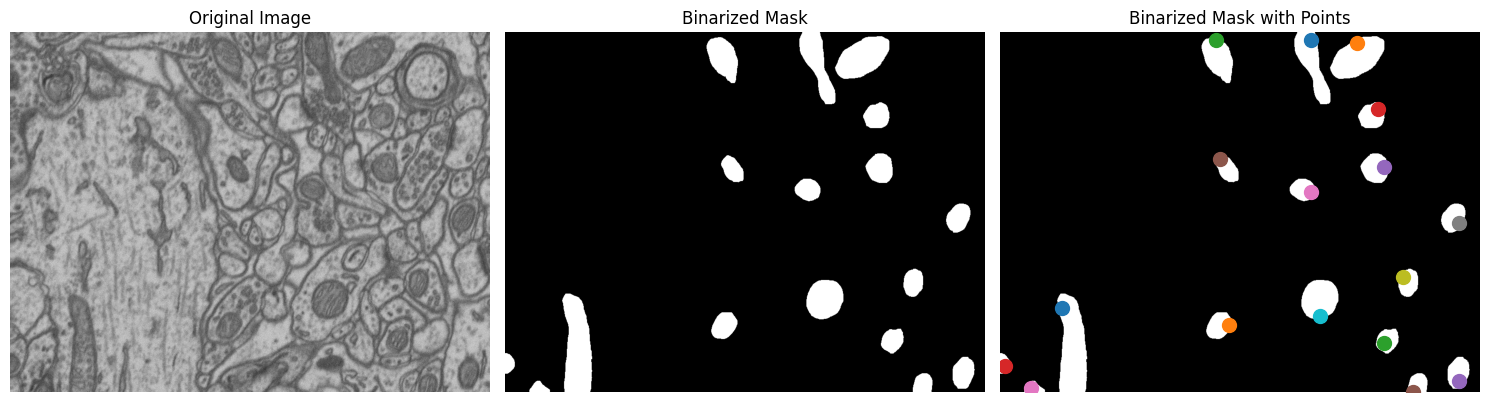

In [33]:
# Original SAM2 inference (without LoRA)
predictor_original = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

# Generate random points for the input
image, mask, input_point, num_masks = read_batch(test_data, visualize_data=True)

input_label = np.ones([input_point.shape[0], 1])
org_mask = mask

with torch.no_grad():
    predictor_original.set_image(image)
    masks, scores, logits = predictor_original.predict(
        point_coords=input_point,
        point_labels=input_label
    )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map_original = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
    mask = sorted_masks[i]
    if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
        continue

    mask_bool = mask.astype(bool)
    mask_bool[occupancy_mask] = False
    seg_map_original[mask_bool] = i + 1
    occupancy_mask[mask_bool] = True

# SAM2 with Lora

In [9]:
# Load the selected image and mask
image, mask = read_image(image_path, mask_path)
org_mask = mask

# Generate random points for the input
num_samples = 2
input_points = get_points(mask, num_samples)

# Load the original SAM2 model
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Apply LoRA weights
sam2_model_with_lora = add_lora_to_model(sam2_model, lora_weights)

# Build net and load weights
predictor_lora = SAM2ImagePredictor(sam2_model_with_lora)

# Perform inference and predict masks with LoRA
with torch.no_grad():
    predictor_lora.set_image(image)
    masks_lora, scores_lora, logits_lora = predictor_lora.predict(
        point_coords=input_points,
        point_labels=np.ones([input_points.shape[0], 1])
    )

# Process the predicted masks and sort by scores (LoRA)
np_masks_lora = np.array(masks_lora[:, 0])
np_scores_lora = scores_lora[:, 0]
sorted_masks_lora = np_masks_lora[np.argsort(np_scores_lora)][::-1]

# Initialize segmentation map and occupancy mask (LoRA)
seg_map_lora = np.zeros_like(sorted_masks_lora[0], dtype=np.uint8)
occupancy_mask_lora = np.zeros_like(sorted_masks_lora[0], dtype=bool)

# Combine masks to create the final segmentation map (LoRA)
for i in range(sorted_masks_lora.shape[0]):
    mask = sorted_masks_lora[i]
    if (mask * occupancy_mask_lora).sum() / mask.sum() > 0.15:
        continue

    mask_bool = mask.astype(bool)
    mask_bool[occupancy_mask_lora] = False
    seg_map_lora[mask_bool] = i + 1
    occupancy_mask_lora[mask_bool] = True


TypeError: Invalid shape (1, 768, 1024) for image data

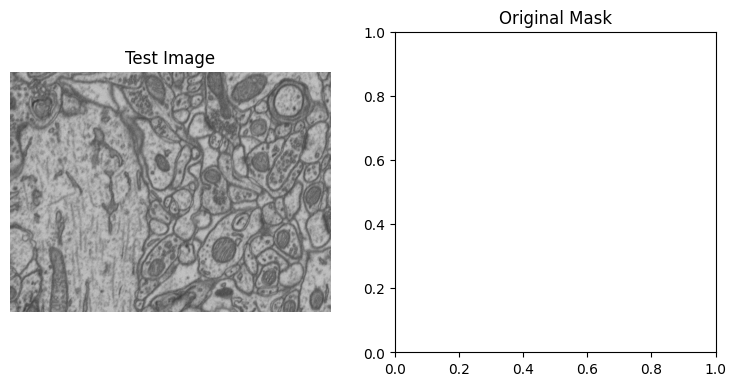

In [34]:
# Visualization
plt.figure(figsize=(24, 6))

plt.subplot(1, 5, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Original Mask')
plt.imshow(org_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Original SAM2 Mask')
plt.imshow(seg_map_original, cmap='jet')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title('SAM2 with LoRA Mask')
plt.imshow(seg_map_lora, cmap='jet')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Difference (LoRA - Original)')
plt.imshow((seg_map_lora - seg_map_original) != 0, cmap='bwr')
plt.axis('off')

plt.tight_layout()
plt.show()